In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col='year', header=0, names=['year', 'gdp'])
#df.columns.rename({'GDP (current US$)': 'gdp'}, inplace=True)
df.columns

Index(['gdp'], dtype='object')

In [3]:
df

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


<AxesSubplot:xlabel='year'>

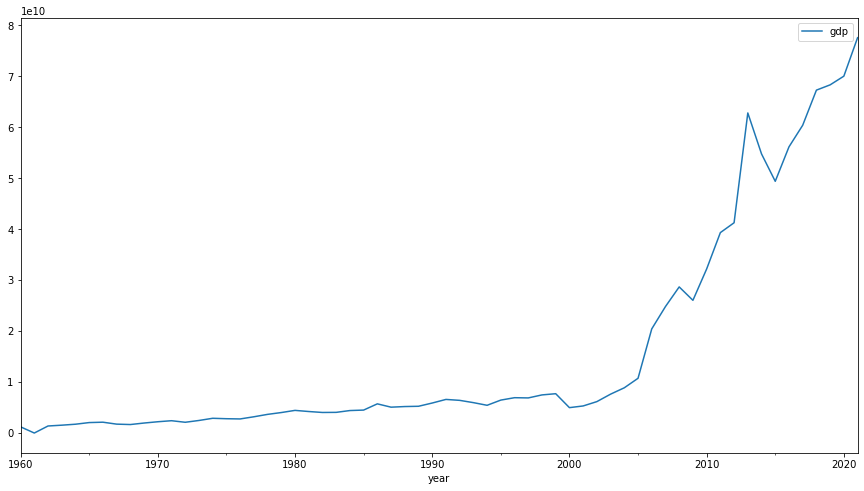

In [4]:
plt.rcParams["figure.figsize"] = 15, 8
df.plot()

In [5]:
train_df = df.loc[:'2018-01-01']
test_df = df.loc['2019-01-01':]
test_df

,gdp
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


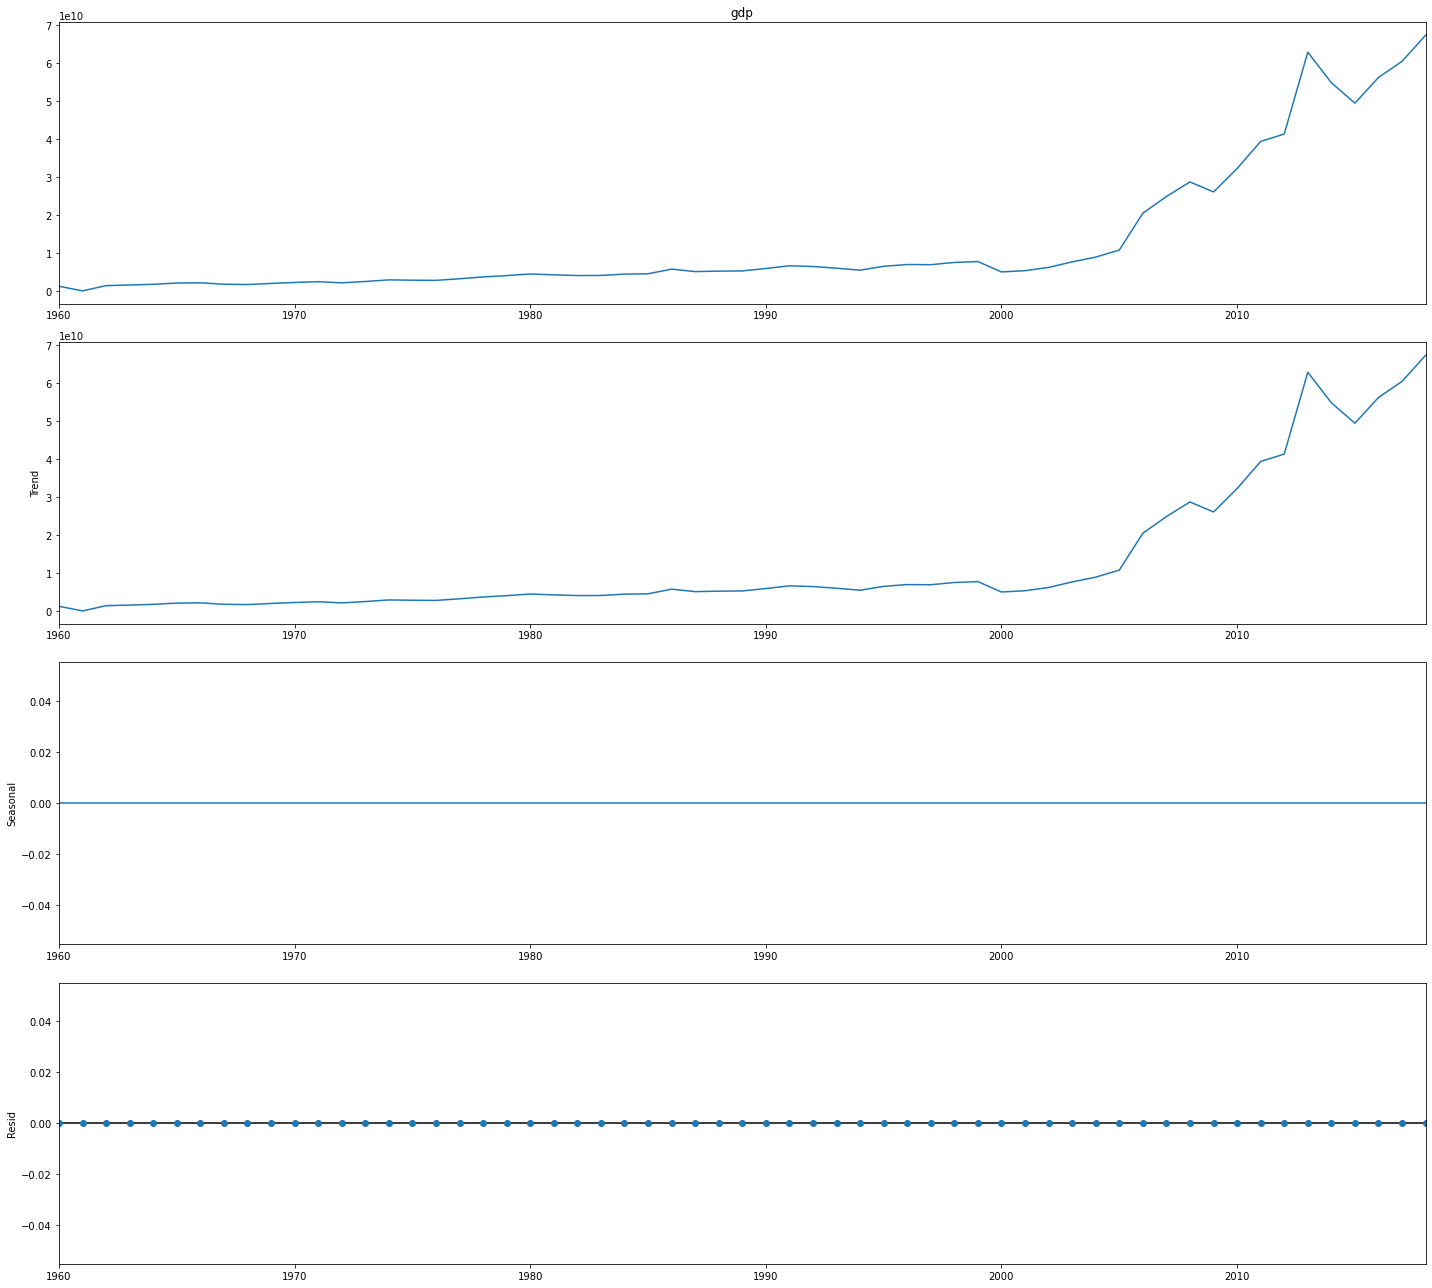

In [6]:
plt.rcParams['figure.figsize'] = 20, 18
result = seasonal_decompose(train_df.gdp, model='additive')
result.plot()
plt.show()

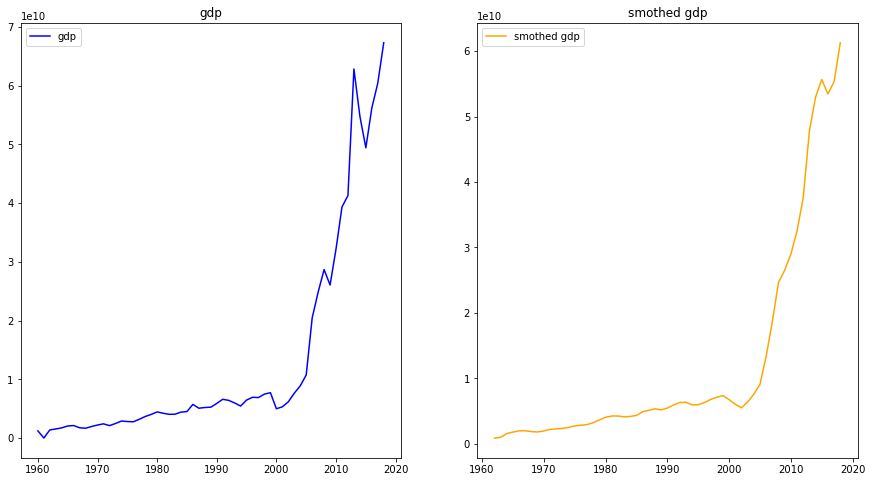

In [7]:
plt.rcParams['figure.figsize'] = 15, 8

fig, ax = plt.subplots(1, 2)
ax[0].plot(train_df.gdp, color='blue', label='gdp')
ax[0].set_title('gdp')
ax[0].legend()

ax[1].plot(train_df.gdp.rolling(window=3).mean(), color='orange', label='smothed gdp')
ax[1].set_title('smothed gdp')
ax[1].legend()

In [8]:
q = 3

In [9]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print('adf: ', test[0])
    print('pvalue: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('Есть единичные корни, ряд не стационарен')
        return False
    else:
        print('Единичных корней нет')
        return True
        
        
stat_test(train_df)

adf:  0.6529066974885355
pvalue:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен


False

Так как ряд не стационарен, будем использовать ARIMA для обучения модели

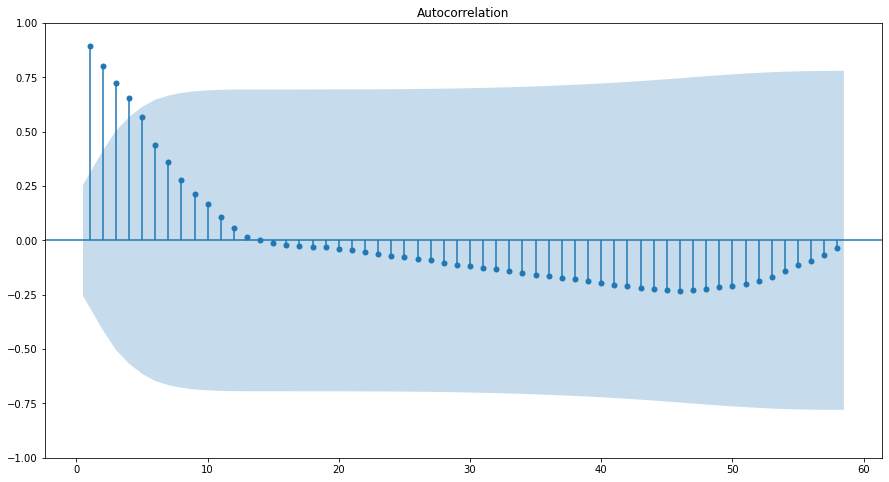

In [10]:
plt.rcParams['figure.figsize'] = 15, 8
sgt.plot_acf(train_df.gdp, zero=False, lags=58)
plt.show()

In [11]:
df_diff_1 = train_df.copy()
d = 0
for i in range(1, 10):
    df_diff_1 = df_diff_1.diff(periods=1).dropna()
    if(stat_test(df_diff_1)):
        d = i
        break
        
print("d =", d)

adf:  -1.6702483038320772
pvalue:  0.4465029329713892
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Есть единичные корни, ряд не стационарен
adf:  -2.6408690561284858
pvalue:  0.08484116917837747
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Есть единичные корни, ряд не стационарен
adf:  -4.779623784828528
pvalue:  5.9483276402250296e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Единичных корней нет
d = 3


/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


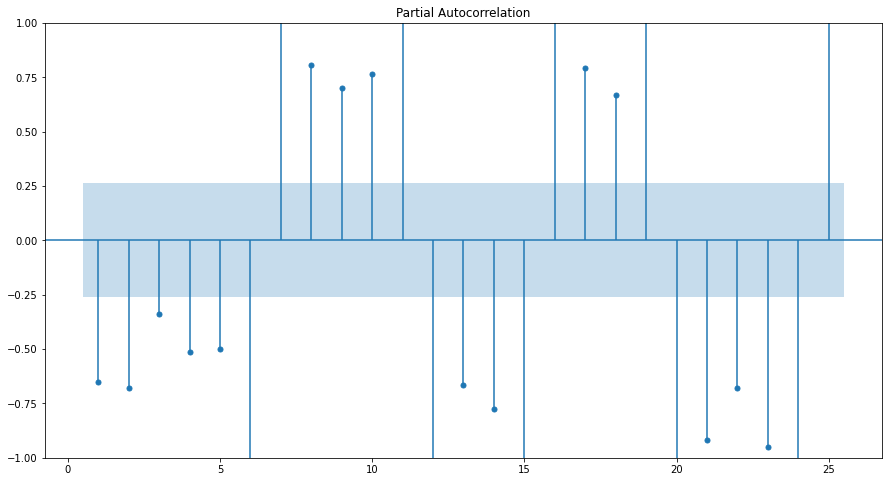

In [12]:
plt.rcParams['figure.figsize'] = 15, 8
sgt.plot_pacf(df_diff_1, zero=False, lags=25)
plt.show()

p сложно определить из этой корелограммы

In [13]:
p = 5

In [14]:
smodel = pm.auto_arima(
    train_df,
    start_p=1, max_p=5,
    start_q=1, max_q=5,
    test='adf',
    m=5,
    seasonal=False,
    d=d,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    trace=True
)
print(p, d, q)
smodel.summary()

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (5) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.04 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.08 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.05 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.08 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.04 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.870 seconds
5 3 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 05 Nov 2022   AIC                           2659.231
Time:                        13:30:07   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+57. Standard errors may be unstable.
"""

In [15]:
p = 2
d = 3
q = 1

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [17]:
am = ARIMA(train_df.gdp.dropna(), order=(p, d, q))
am_fit = am.fit()
am_fit.summary()

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 05 Nov 2022   AIC                           2659.231
Time:                        13:30:07   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+57. Standard errors may be unstable.
"""

In [18]:
pred_df = pd.DataFrame(index=df.index)
pred_df['preds'] = am_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['gdp'] = df['gdp']
pred_df

,preds,gdp
year,,
1960-01-01,NaN,1.217087e+09
1961-01-01,NaN,0.000000e+00
1962-01-01,NaN,1.382353e+09
1963-01-01,NaN,1.540616e+09
1964-01-01,NaN,1.731092e+09
...,...,...
2017-01-01,NaN,6.040638e+10
2018-01-01,NaN,6.729928e+10
2019-01-01,7.368591e+10,6.833754e+10


In [19]:
forecast = am_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_pred_lower"] = forecast_df['lower gdp']
pred_df.at[test_df.index, "model_pred_upper"] = forecast_df['upper gdp']
pred_df

,preds,gdp,model_pred_lower,model_pred_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.368591e+10,6.833754e+10,6.269386e+10,8.467796e+10


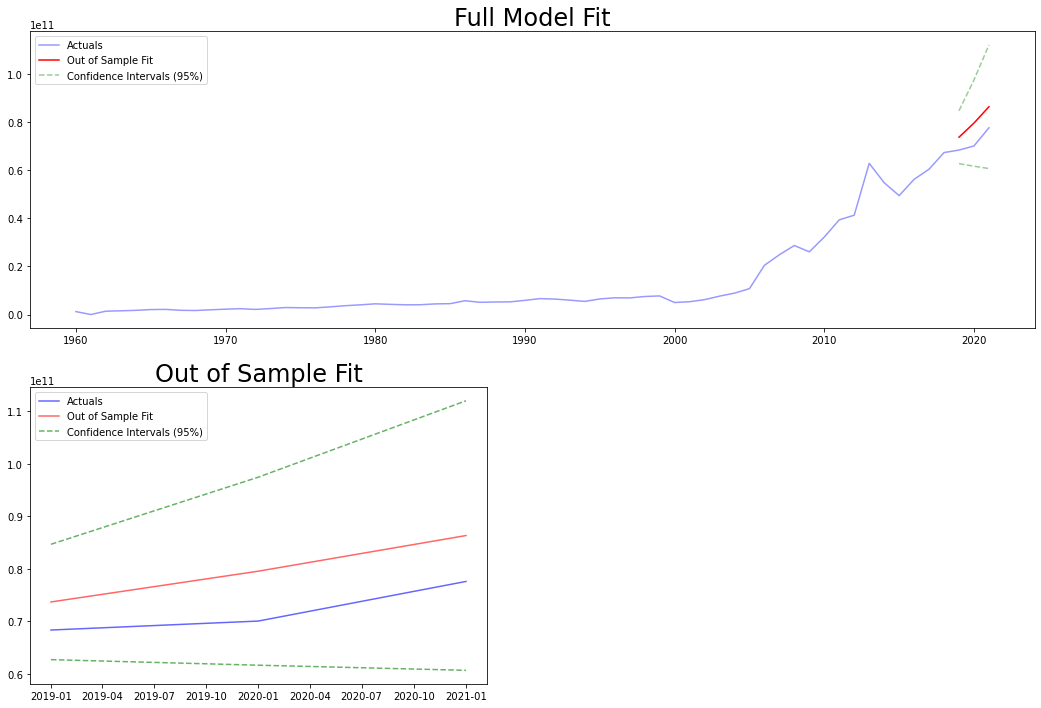

In [20]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_pred_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_pred_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["gdp"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_pred_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_pred_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Вывод: лучше всего отрабатывает модель ARIMA, сезонности в данных не наблюдается, ряд не стационарен

**Интерполяция**

In [21]:
df.asfreq(freq='AS').isnull().sum()

gdp    0
dtype: int64

Пропущенных дат нет

In [22]:
df.gdp.isnull().sum()

0

Пропусках в значениях нет

In [23]:
df['gdp'] = df['gdp'].apply(lambda x: np.nan if x==0 else x)
df.gdp.isnull().sum()

1

Есть значение 0

In [24]:
df['gdp'] = df['gdp'].interpolate(method='linear')

In [25]:
train_df = df.loc[:'2018-01-01']
test_df = df.loc['2019-01-01':]
test_df

,gdp
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [26]:
stat_test(train_df)

adf:  0.8030073326980104
pvalue:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен


False

In [27]:
smodel = pm.auto_arima(
    train_df,
    start_p=1, max_p=5,
    start_q=1, max_q=5,
    test='adf',
    m=5,
    seasonal=False,
    d=d,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    trace=True
)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.04 sec


/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (5) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.05 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.06 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.07 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.878 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sat, 05 Nov 2022   AIC                           2659.226
Time:                        13:30:09   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.49e+56. Standard errors may be unstable.
"""

In [28]:
p = 2
d = 3
q = 1

In [29]:
am = ARIMA(train_df.gdp, order=(p, d, q))
am_fit = am.fit()
am_fit.summary()

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sat, 05 Nov 2022   AIC                           2659.226
Time:                        13:30:09   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.49e+56. Standard errors may be unstable.
"""

In [30]:
pred_df = pd.DataFrame(index=df.index)
pred_df['preds'] = am_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['gdp'] = df['gdp']
forecast = am_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_pred_lower"] = forecast_df['lower gdp']
pred_df.at[test_df.index, "model_pred_upper"] = forecast_df['upper gdp']
pred_df

,preds,gdp,model_pred_lower,model_pred_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,1.299720e+09,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.369000e+10,6.833754e+10,6.269699e+10,8.468301e+10


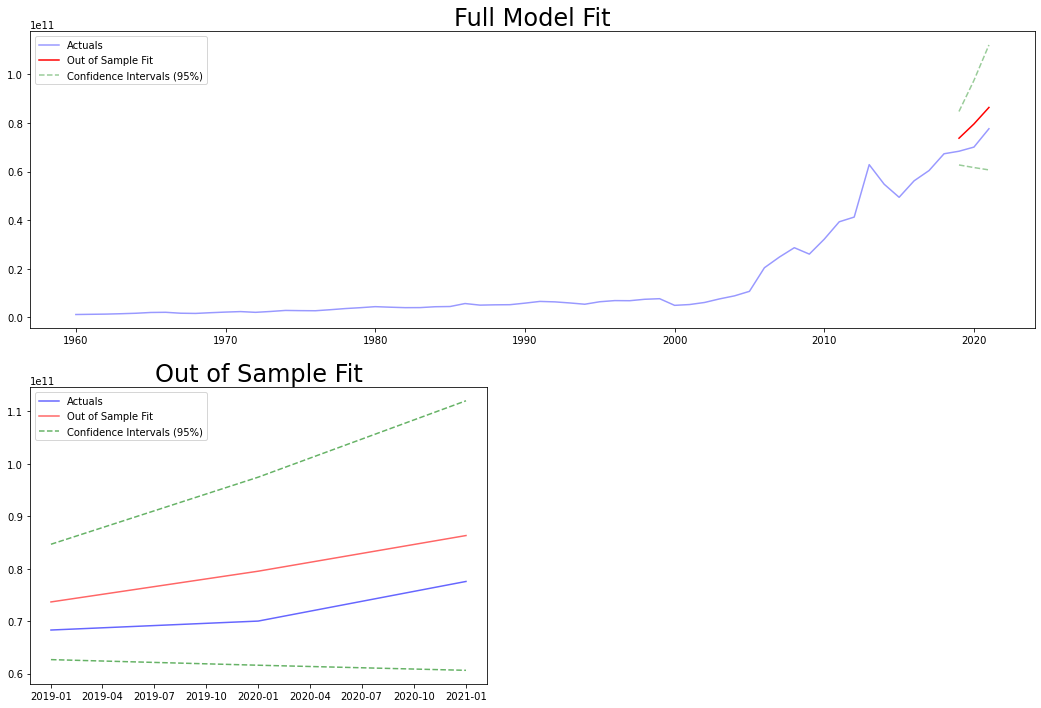

In [31]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_pred_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_pred_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["gdp"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_pred_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_pred_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

После интерполяции значение aic не изменилось. В целом интероляция не повлияла на предсказание модели, что логично. Вывод - интерполяция в среднем не ухудшает прогноз и дает возможность более гибко подходить к выбору переодичности

**Волатильность**

In [33]:
df['gdp_vol'] = df.gdp.pct_change(1).mul(100).abs()
df['gdp_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

<AxesSubplot:xlabel='year'>

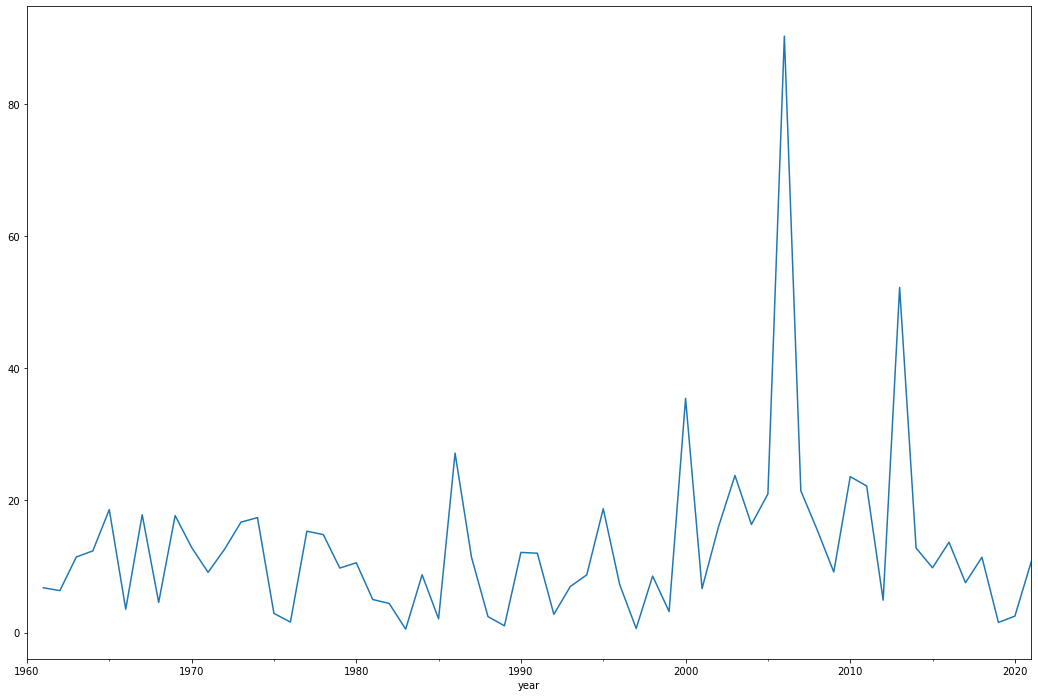

In [34]:
df.gdp_vol.plot()

Из графика видно, что дисперсия очень высокая и имеет скачки в некоторых периодах. Следует ее учитывать в предсказании

In [35]:
train_df = df.loc[:'2018-01-01']
test_df = df.loc['2019-01-01':]

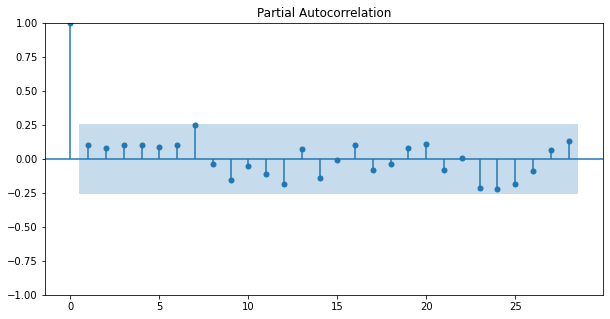

In [37]:
plt.rcParams['figure.figsize'] = 10, 5
sgt.plot_pacf(train_df.gdp_vol[1:], lags=28)
plt.show()

In [ ]:
p = 7

In [38]:
from statsmodels.tsa.stattools import adfuller

In [40]:
adfuller(train_df.gdp_vol[1:])

(-6.725311059553777,
 3.4014596148856737e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Ряд стационарен

In [41]:
from arch import arch_model

In [43]:
garch_df = pd.DataFrame(df['gdp_vol'].shift(1).loc[df.index])
garch_df.head()


,gdp_vol
year,
1960-01-01,NaN
1961-01-01,NaN
1962-01-01,6.789413
1963-01-01,6.357759
1964-01-01,11.448835


In [44]:
model = arch_model(garch_df.gdp_vol.dropna(), p=p, q=2, vol='GARCH')
model_result = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 224.93433348478635
Iteration:     10,   Func. Count:     74,   Neg. LLF: 222.99500246093626
Iteration:     15,   Func. Count:    109,   Neg. LLF: 222.9665498362726
Iteration:     20,   Func. Count:    143,   Neg. LLF: 222.86320690723983
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.8632078624438
            Iterations: 21
            Function evaluations: 143
            Gradient evaluations: 20


In [45]:
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -222.863
Distribution:                  Normal   AIC:                           457.726
Method:            Maximum Likelihood   BIC:                           469.985
                                        No. Observations:                   57
Date:                Sat, Nov 05 2022   Df Residuals:                       56
Time:                        15:03:01   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3151      2.122      5.802  6.541e-09 [  8.155, 16.475]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.7859     13.758      0.275      0.783 [-23.180, 30.751]
alpha[1]   4.9862e-11      0.102  4.871e-10      1.000 [ -0.201,  0.201]
alpha[2]   3.1934e-11      0.143  2.236e-10      1.000 [ -0.280,  0.280]
beta[1]        1.0000      0.896      1.117      0.264 [ -0.755,  2.755]
beta[2]        0.0000      0.888      0.000      1.000 [ -1.740,  1.740]
========================================================================

Covariance estimator: robust
"""

In [50]:
test_df

,gdp,gdp_vol
year,,
2019-01-01,6.833754e+10,1.542746
2020-01-01,7.004320e+10,2.495937
2021-01-01,7.759428e+10,10.780603


In [47]:
prediction_df = test_df.copy()
prediction_df['prediction'] = model_result.forecast().residual_variance.loc[test_df.index]

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [51]:
prediction_df

,gdp,gdp_vol,prediction
year,,,
2019-01-01,6.833754e+10,1.542746,291.826127
2020-01-01,7.004320e+10,2.495937,295.612047
2021-01-01,7.759428e+10,10.780603,299.397966


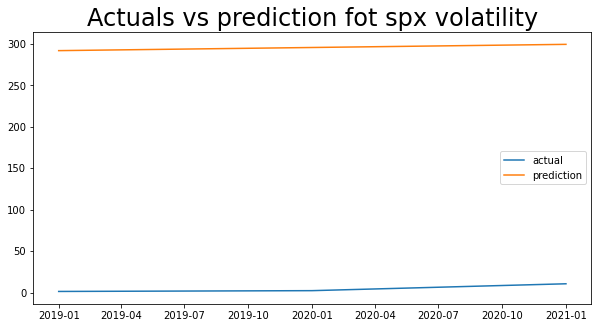

In [55]:
plt.rcParams['figure.figsize'] = 10, 5
plt.plot(prediction_df['gdp_vol'], label='actual')
plt.plot(prediction_df['prediction'], label='prediction')

plt.title('Actuals vs prediction fot spx volatility', size=24)
plt.legend()
plt.show()

In [56]:
from sklearn import linear_model

In [63]:
X_train = pd.DataFrame(range(df['gdp_vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(df['gdp_vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['gdp_vol'].fillna(0)
y_test = test_df['gdp_vol'].fillna(0)

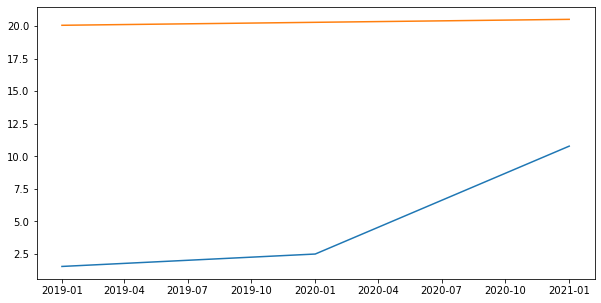

In [64]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
lr_predictioin = lr.predict(X_test)

plt.plot(y_test)
plt.plot(pd.Series(lr_predictioin, index=y_test.index))

Линейная модель показала лучший результат чем garch, но тоже в целом не уловила зависимости. В целом garch модель не уловила дисперсию, как сказано в модуле, видимо потому, что в тестовые данные отличались от обучающих и были для модели новыми.